<a href="https://colab.research.google.com/github/samuel-verburg/EEA-summer-school-2025/blob/main/exercise1_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### EAA Summer School 2025: Measurement Methods for Sound Field Analysis, Reconstruction, and Reproduction
**Exercise 1: Sound Field Reconstruction, Wave Expansions, and Regularization**

**Introduction**

Sound field reconstruction consists of estimating an acoustic field over time and space from a limited number of observations. These observations could correspond, for example, to measurements captured with a microphone array or a distribution of sensors.  
Typically, in order to interpolate or extrapolate between or away from the measured positions, we need to fit a model of the sound field to the observed data. Elementary wave expansions are some of the most common models used in sound field reconstruction.

In this notebook, you will learn to:
- Expand a sound field using elementary wave functions.
- Estimate the wave coefficients (i.e., their complex amplitudes).
- Regularize the problem to obtain a unique, stable solution and/or promote particular solutions.
- Reconstruct a sound field from limited observations.  

To solve the optimization problem, we are going to use the package [`cvxpy`](https://www.cvxpy.org/index.html) for convex optimization. If you run this notebook in Colab, you don't need to install anything.  
If you are using Matlab, you can download and install the package [`cvx`](https://cvxr.com/cvx/doc/install.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

We start by defining a couple of functions that compute simple sound fields. These will serve to synthesize the data necessary for the exercise.

- The function `Greens_free_field` computes the free-field Green's function between a receiver positioned at $\mathbf{r}$ and a source at $\mathbf{r}_0$:
$$
G(\mathbf{r},\mathbf{r}_0) = \frac{\text{e}^{\text{j} (\omega t - k R)}}{4 \pi R},
$$
where $R$ is the distance between source and receiver, $k$ is the wavenumber, $\omega$ is the angular frequency, and $t$ is the time. Note that we are considering harmonic sound fields and will drop the term $e^{j\omega t}$ for the calculations.

- The function `Greens_room` computes the Green's function in a 2D rectangular domain of dimensions $L_x, L_y$ with lightly damped boundaries. This could resemble the sound field inside a room at low frequencies:
$$
G(\mathbf{r},\mathbf{r}_0) = \frac{-1}{L_x L_y}\sum_{n} \frac{\Psi_n(\mathbf{r}) \Psi_n(\mathbf{r}_0)}{k^2 - k_n^2 - jk / (\tau c)} \text{e}^{\text{j} \omega  t},
$$
where $k_n = \sqrt{(\pi n_x / L_x)^2 + (\pi n_y / L_y)^2}$ is the wavenumber of mode $n=(n_x,n_y)$, $\tau$ is a time constant that controls the damping (assumed the same for all modes), and $\Psi_n$ are the mode shapes:
$$
\Psi_n(\mathbf{r}) = \cos(\pi n_x x / L_x) \cos(\pi n_y y / L_y).
$$

For simplicity, we will consider 2D simulations and wave expansions.

In [2]:
def Greens_free_field(x, y, x0, y0, f, c):
    """Compute the 2D Green's function in free field."""
    """
    Parameters:
    x, y : np.ndarray
        Receiver coordinates.
    x0, y0 : float
        Source coordinates.
    f : float
        Frequency.
    c : float
        Speed of sound.
    Returns:
    G : np.ndarray
        The computed Green's function at the specified coordinates.
    """
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    k = 2 * np.pi * f / c
    G = np.exp(-1j * k * r) / (4 * np.pi * r)
    return G

def Greens_room(x, y, x0, y0, Lx, Ly, Nx, Ny, f, tau, c):
    """Compute the 2D Green's function in a lightly damped rectangular domain."""
    """
    Parameters:
    x, y : np.ndarray
        Receiver coordinates.
    x0, y0 : float
        Source coordinates.
    Lx, Ly : float
        Dimensions of the rectangular domain.
    Nx, Ny : int
        Number of modes in the x and y directions.
    f : float
        Frequency.
    tau : float
        Time constant (damping).
    c : float
        Speed of sound.
    Returns:
    G : np.ndarray
        The computed Green's function at the specified coordinates.
    """
    def mode_shapes(nx, ny, x, y):
        return np.cos(np.pi * nx * x / Lx) * np.cos(np.pi * ny * y / Ly)

    k = 2 * np.pi * f / c
    G = 0
    for nx in range(Nx):
        for ny in range(Ny):
            mode_xy = mode_shapes(nx, ny, x, y)
            mode_x0y0 = mode_shapes(nx, ny, x0, y0)
            k_n = np.sqrt((np.pi * nx / Lx)**2 + (np.pi * ny / Ly)**2)
            G += mode_xy * mode_x0y0 / (k**2 - k_n**2 - 1j*k / (tau * c))
    return -G/(Lx * Ly)



We define some parameters like the speed of sound, frequency of the sound field, dimensions of the room, number of modes, and damping.

We then compute the resulting sound field on a fine grid. This will be the reference against which we will compare the reconstructed sound field.

In [3]:
# Define parameters
c = 343
f = 89.3
Lx, Ly = 5.0, 3.0
Nx, Ny = 10, 10
x0, y0 = 0.1, 0.1
tau = 0.5

# Compute the Green's function on a grid
X, Y = np.meshgrid(np.linspace(0, Lx, int(Lx*100)), np.linspace(0, Ly, int(Ly*100)))
r_rec = np.array([X.flatten(), Y.flatten()]).T
p_ref = Greens_room(r_rec[:, 0], r_rec[:, 1], x0, y0, Lx, Ly, Nx, Ny, f, tau, c)

**ex1.0**:

To simulate measurements with a microphone array, take `m = 15` random samples from the grid. We need both the positions `r` and the pressure at those positions `p`.  
An easy way to do this is by sampling some indices using

`indices = np.random.choice(p_ref.size, m, replace=False)`

and then getting the positions and pressure values for those indices.

**ex1.1**:

When dealing with measured data, there will always be noise. Therefore, we need to add noise to the observations. To get `m` random numbers from a standard normal distribution, you can use

`np.random.randn(m)`

Remember that since we are working in the frequency domain, the pressure is complex, so you need to add complex-valued noise. Scale the noise to obtain a "reasonable" signal-to-noise ratio (e.g., 20 dB).


In [4]:
# Here comes your code:

np.random.seed(42)
m = 15
indices = np.random.choice(p_ref.size, m, replace=False)
p = p_ref[indices]
p += 0.1 * (np.random.randn(m) + 1j * np.random.randn(m)) * np.sqrt(np.mean(np.abs(p)**2))
r = r_rec[indices]




The following cell plots a figure of the reference and sampled locations to check what we have done so far.

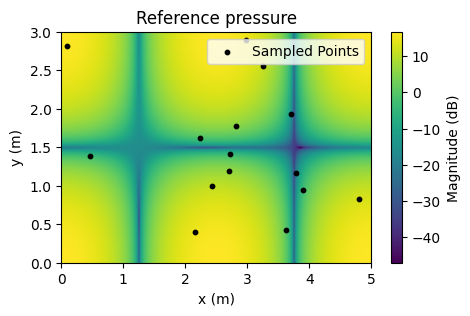

In [5]:
# Figure of the reference pressure over space and the sampled points
fig = plt.figure(figsize=(5, 3))
im = plt.imshow(20 * np.log10(np.abs(p_ref)).reshape(X.shape), extent=(0, Lx, 0, Ly), aspect='auto', cmap='viridis')
plt.scatter(r[:, 0], r[:, 1], c='black', s=10, label='Sampled Points')
plt.legend(loc='upper right')
fig.colorbar(im, label='Magnitude (dB)')
plt.title('Reference pressure')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

**Plane wave expansion.**

One of the most common models in sound field reconstruction is the plane wave expansion, in which the sound field is expressed as the sum of a finite number of propagating plane waves:

$$
p(\mathbf{r}, t) = \sum_{i=0}^{n-1} x_i \text{e}^{\text{j} (\omega t - \mathbf{k}_i \cdot \mathbf{r})}
$$

where $n$ is the number of plane waves in the expansion, and $x_i$ is the coefficient of the $i^\text{th}$ wave. These coefficients are complex numbers that represent the amplitude and phase of each wave. We do not know the $x_i$ in principle, and they are precisely what we want to estimate from the measurements. Once these coefficients are estimated, it is possible to approximate the sound field at any position (more on that later).

The exponential term $\text{e}^{-\text{j} \mathbf{k}_i \cdot \mathbf{r}}$ accounts for the wave propagation, which is just a phase shift since we are considering plane waves. The term $\mathbf{k}_i$ is the wavenumber vector of the $i^\text{th}$ wave. For propagating plane waves, this vector points in the direction of propagation, i.e., $\mathbf{k}_i = k(\cos(\theta_i), \sin(\theta_i))$, with $k= 2 \pi f / c$. It is up to us to define the wave directions. Typically, the angles $\theta_i$ are uniformly sampled on the unit circle (in 2D) or on the unit sphere (in 3D).

Here, we consider that the sound field is composed only of propagating plane waves. This is a valid assumption far from sound sources, but a "full" solution would also include evanescent waves [Williams1999].

Since we have multiple measurements, it is convenient to express the wave expansion algebraically:

$$
\mathbf{p} = \mathbf{A} \mathbf{x} + \mathbf{n},
$$

where $\mathbf{p}\in \mathbb{C}^m$ contains the pressure at the measurement positions, $\mathbf{A} \in \mathbb{C}^{m\times n}$ is a matrix whose elements are the complex exponentials $a_{i,j} = \text{e}^{-\text{j} \mathbf{k}_i \cdot \mathbf{r}_j}$, $\mathbf{x}\in \mathbb{C}^n$ contains the unknown wave coefficients, and $\mathbf{n}\in \mathbb{C}^m$ is a noise term. Note that this noise term combines both the measurement noise and a possible discrepancy between the actual sound field and the plane wave model.

**ex1.2**:

Create a plane wave expansion matrix.
- Get the angles `thetas` for `n = 360` directions.
- Compute the wavenumber vector for each direction. You will get an array `k` of size `(n, 2)`.
- Compute the plane wave expansion matrix `A` using the wavenumber vectors `k` and the measurement positions `r`.

In [ ]:
# Here comes your code:

n = 360
thetas = np.linspace(0, 2 * np.pi, n)

k = 2*np.pi*



**Optimization problem.**

The previous expression, $\mathbf{p} = \mathbf{A} \mathbf{x} + \mathbf{n}$, is a linear system of equations with $n$ unknowns (one for each wave coefficient in the expansion) and $m$ equations (one for each sensor in the array). The goal is to estimate $\mathbf{x}$ from the measurements $\mathbf{p}$. However, this is most likely an ill-posed problem because:

- We only have access to a limited number of measurements. Typical microphone arrays have, at most, a few tens of microphones, and practically deploying hundreds of sensors over space is impractical and costly. Therefore, the number of unknowns is likely larger than the number of equations, and thus there are infinitely many solutions to the system of equations.

- The matrix $\mathbf{A}$ is ill-conditioned. That means that some of its rows or columns are linearly dependent. Linear dependency of the rows can be avoided by distributing the sensors over space. However, the column linear dependency comes from the plane wave expansion model, and there is not much we can do about it. An ill-conditioned $\mathbf{A}$ makes the solutions extremely sensitive to small perturbations in the input data, such as noise, leading to erroneous estimations [Hansen1998].

A naive way of solving this problem would be the least-squares solution

$$
\tilde{\mathbf{x}}_\text{ls} = \arg \min_{\mathbf{x}\in \mathbb{C}^n} \| \mathbf{A} \mathbf{x} - \mathbf{p} \|^2_2
$$

The solution $\tilde{\mathbf{x}}_\text{ls}$ is the one that minimizes the Euclidean distance between the measurements and the fitted model. Even though it's simple, this solution will fail if $\mathbf{A}$ is ill-conditioned, since the noise will be largely amplified. You can check the conditioning of $\mathbf{A}$ by computing its condition number, i.e., the ratio between the largest and smallest singular values. A large condition number indicates that the problem is very sensitive to small perturbations in the data [Hansen1998].

In [ ]:
cond_A = np.linalg.cond(A)
print(f"Condition number of A: {cond_A:.2e}")

Condition number of A: 8.04e+05


**Regularization.**

Regularization methods can help us solve ill-posed problems by including additional constraints to arrive at unique, stable solutions.

- **$\ell_2$ regularization**

Arguably the most common regularization is $\ell_2$ regularization, also known as Tikhonov regularization or ridge regression. This regularization aims to find the solution that both fits the data and has minimum energy:

$$
\tilde{\mathbf{x}}_\text{l2} = \arg \min_{\mathbf{x}\in \mathbb{C}^n} \| \mathbf{A} \mathbf{x} - \mathbf{p} \|^2_2 + \alpha \| \mathbf{x} \|^2_2
$$

You can see that the first term is similar to the least-squares solution, but we add a second term that penalizes large $\| \mathbf{x} \|^2_2$. In this way, we control the energy of the solution so that it doesn't "explode" due to ill-conditioning. The parameter $\alpha$ controls the relative weight of the two terms. There are many different ways to choose $\alpha$ automatically (L-curve criterion, generalized cross-validation, discrepancy principle, etc.), but to keep it simple, we will just choose it manually.

$\ell_2$ regularization is simple, efficient, and well understood. It can be shown that applying this regularization has a low-pass filter effect on the solution, and therefore the estimated coefficients $\tilde{\mathbf{x}}_\text{l2}$ tend to be smooth, with many coefficients that are non-zero. $\ell_2$ regularization effectively filters out the noise, but sometimes a smooth solution is not desirable, for example, if we know beforehand that the sound field can be expressed by just a few plane waves.

- **$\ell_1$ regularization**

A more recent but popular strategy is $\ell_1$ regularization, also known as compressive sensing or lasso regression. In this case, the regularization aims to find the solution that fits the data and has minimum $\ell_1$ norm [Candes2008]:

$$
\tilde{\mathbf{x}}_\text{l1} = \arg \min_{\mathbf{x}\in \mathbb{C}^n} \| \mathbf{A} \mathbf{x} - \mathbf{p} \|^2_2 + \alpha \| \mathbf{x} \|_1
$$

where the $\ell_1$ norm is the sum of the magnitudes of the vector elements:

$$
\| \mathbf{x} \|_1 = \sum_{i=0}^n |x_i|.
$$

It can be shown that $\ell_1$ regularization promotes sparse solutions, i.e., solutions with a small number of non-zero entries. Therefore, unlike the $\ell_2$ solutions, $\tilde{\mathbf{x}}_\text{l1}$ is not smooth. This is very convenient when we know that the sound field can be represented by a few of the expansion functions. For example, for the case of the rectangular room, we know that the mode shapes are a product of two cosines corresponding to standing waves in the room, and each of these cosines can be expressed as the sum of two propagating plane waves. Therefore, we only need four waves out of the 360 to describe the sound field at a modal frequency [Kuttruff2024].

While there is no closed-form solution, the $\ell_1$ norm is convex, and therefore it can be solved efficiently.
There is a whole field of research in signal processing dedicated to compressive sensing and sparse signal recovery, which aims to recover signals with extremely limited data (well below the Nyquist sampling rate) based on their sparsity in some representation domain. For an excellent introduction, see [Candes2008].

**ex1.3**:

Solve the optimization problem for:
- The least-squares solution, `x_ls`
- With $\ell_2$ regularization, `x_l2`
- With $\ell_1$ regularization, `x_l1`

The syntax for using the `cvxpy` package is very simple. For example, if we want to solve the least-squares problem, we first define a complex variable of size `n`:

`x_ls = cp.Variable(n, complex=True)`

Then we define the cost function that we want to minimize:

`cost = cp.sum_squares(A @ x_ls - p)`

Next, we create a problem object:

`prob = cp.Problem(cp.Minimize(cost))`

and finally solve it:

`prob.solve()`

We get the estimated values by calling:

`x_ls.value`

In [ ]:
# Here comes your code:

**ex1.4**:

Plot the magnitude of the coefficients you found as a function of the directions $\theta_i$.
Does it look like what you expect?

Note that the magnitude of the least-squares solution can be completely off, so you might need to adjust the figure or plot it in a separate figure.

Experiment with different regularization parameters, `alpha_l2` and `alpha_l1`, and see how the results change. You can also change the frequency of the sound field, the number of measurements, and the damping of the modes.

In [ ]:
# Here comes your code:

**Reconstruction**

Once the wave coefficients are estimated, we can reconstruct the sound field at positions other than the measured ones by evaluating the plane wave model at those positions:

$$
\tilde{p}(\mathbf{r}_\text{rec}, t) = \sum_{i=0}^{n-1} \tilde{x}_i \text{e}^{\text{j} (\omega t - \mathbf{k}_i \cdot \mathbf{r}_\text{rec})}
$$

or in matrix form:

$$
\tilde{\mathbf{p}}_\text{rec} = \mathbf{B} \tilde{\mathbf{x}}
$$

where the matrix $\mathbf{B}$ contains the complex exponentials evaluated at the reconstruction positions, and $\tilde{\mathbf{x}}$ is the estimated wave coefficients (e.g., the least-squares, $\ell_2$, or $\ell_1$ solutions).


**ex1.5**:

- Compute the reconstructed pressure at the original grid positions `r_rec` by first forming the matrix `B` and then multiplying it by the different solutions: `x_ls`, `x_l2`, and `x_l1`.

- Plot the results in a figure and compare them with the reference field.


In [ ]:
# Here comes your code:

**Bonus exercises / deliverables**

You can try to solve a similar reconstruction problem, but for a different sound field—namely, the one generated by a point source radiating in free field. For that, you can use the function `Greens_free_field` defined at the top of this notebook. Note that the sound field is now a spherical wave that decays with distance.

- How do the $\ell_2$ and $\ell_1$ solutions compare now? Can you explain the results?

- Is a plane wave expansion a good model for this sound field? Can you think of a different expansion that might be better suited? How would you implement it?

- The $\ell_2$ and $\ell_1$ solutions are just two of many regularization strategies. You can try to implement different regularizations using `cvxpy`. For example, the Elastic Net penalizes both the $\ell_2$ and $\ell_1$ norms at the same time, or Total Variation minimizes $\|\mathbf{Dx}\|_1$, where $\mathbf{D}$ is an $n\times n$ matrix, and $\mathbf{Dx}$ is the discrete approximation of the gradient of $\mathbf{x}$.

- Change the measurement positions to form microphone arrays other than random distributions. What happens to the condition number when you consider smaller, compact arrays?

- What would you need to change to solve the problems in 3D?

In [ ]:
# Here comes your code:

**References**
- [Willians1999] Williams, E. G. (1999). Fourier acoustics: sound radiation and nearfield acoustical holography. Elsevier.
- [Hansen1998] Hansen, P. C. (1998). Rank-deficient and discrete ill-posed problems: numerical aspects of linear inversion. Society for Industrial and Applied Mathematics.
- [Kuttruff2024] Kuttruff, H., & Vorländer, M. (2024). Room acoustics. Crc Press.
- [Candes2008] Candès, E. J., & Wakin, M. B. (2008). An introduction to compressive sampling. IEEE signal processing magazine, 25(2), 21-30.
